<a href="https://colab.research.google.com/github/Atta-UR/Image_Classification_on_Cifar10_Dataset/blob/main/Image_Classification_Using_Cifar10_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries Including the Dataset

In [ ]:
# Importing TensorFlow and Keras libraries for building and training neural networks
import tensorflow as tf
from tensorflow.keras.datasets import cifar10  # CIFAR-10 dataset for image classification
from tensorflow.keras.models import Sequential  # Sequential model for stacking layers linearly
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization  # Layers for CNN construction
from tensorflow.keras.layers import Input  # Import the Input layer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For data augmentation and Image Pre-procssing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.optimizers import Adamax # Optimizer
# Libraries for data visualization and numerical operations
import matplotlib.pyplot as plt  # Used to visualize training progress and augmented images
import numpy as np  # Essential for numerical operations and array manipulation
from tensorflow.keras.applications import VGG16, EfficientNetB0
from tensorflow.keras.applications import ResNet50, ResNet101


# Load and Preprocess the CIFAR-10 Data

In [ ]:
def preprocess_cifar10():
    """
    Load the CIFAR-10 dataset, normalize the images to a range of 0-1,
    and one-hot encode the labels. Additionally, split the test dataset
    into validation and testing sets.

    Returns:
        tuple: Processed training, validation, and testing data.
               (x_train, y_train), (x_val, y_val), (x_test, y_test)
    """
    # Load CIFAR-10 dataset
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Normalize image data to range [0, 1]
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # One-hot encode labels
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    # Split test data into validation and test sets
    x_val, x_test, y_val, y_test = train_test_split(
        x_test, y_test, test_size=0.5, random_state=42
    )

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

(x_train, y_train), (x_val, y_val), (x_test, y_test) = preprocess_cifar10()


# Data Augmentation

In [ ]:
# Create an instance of the ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,          # Randomly rotate images within a range of 15 degrees
    width_shift_range=0.1,      # Randomly shift images horizontally by 10% of the width
    height_shift_range=0.1,     # Randomly shift images vertically by 10% of the height
    horizontal_flip=True,       # Randomly flip images horizontally
    zoom_range=0.1              # Randomly zoom in on images by up to 10%
)

# Fit the data generator on the training dataset to calculate statistics
# (e.g., mean, std) required for certain normalization techniques.
datagen.fit(x_train)

# Visualize Sample Augmented Images

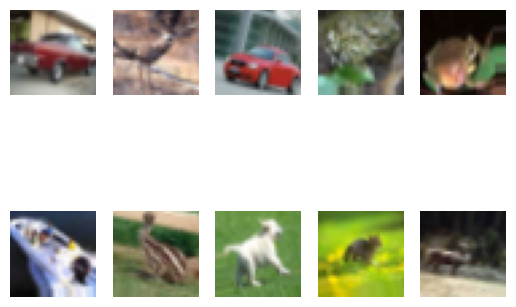

In [ ]:
# Display augmented images
for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=10):
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_batch[i])
        plt.axis('off')
    plt.show()
    break  # Display one batch and stop

# Simple CNN Model With 5X5 Kernal Size

In [ ]:
# Define the CNN model architecture with reduced complexity and 5x5 kernel size
model = Sequential([
    Input(shape=(32, 32, 3)),                      # Explicitly define the input shape

    # Block 1: Conv2D + BatchNormalization + MaxPooling + Dropout
    Conv2D(32, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 2: Conv2D + BatchNormalization + MaxPooling + Dropout
    Conv2D(64, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 3: Conv2D + BatchNormalization + MaxPooling + Dropout
    Conv2D(128, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fully connected layers
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])


# Compiling the Model

In [ ]:
# Compile model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 787,658 (3.00 MB)

 Trainable params: 786,698 (3.00 MB)

 Non-trainable params: 960 (3.75 KB)

# Training the Model

In [ ]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),              # Stop if no improvement
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, verbose=1)                          # Reduce learning rate
]

# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),  # Training data with augmentation
    epochs=50,
    validation_data=(x_val, y_val),              # Validation data
    callbacks=callbacks                            # Add callbacks
)
model.save('/content/drive/MyDrive/simple_model.h5')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 59ms/step - accuracy: 0.2970 - loss: 7.2504 - val_accuracy: 0.3756 - val_loss: 4.5474 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 67s 50ms/step - accuracy: 0.4498 - loss: 3.8283 - val_accuracy: 0.5264 - val_loss: 2.6854 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.5226 - loss: 2.5408 - val_accuracy: 0.6268 - val_loss: 1.8877 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.5769 - loss: 1.9630 - val_accuracy: 0.5640 - val_loss: 1.8916 - learning_rate: 0.0010
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.6029 - loss: 1.7127 - val_accuracy: 0.6260 - val_loss: 1.5616 - learning_rate: 0.0010
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.6255 - loss: 1.5658 - val_accuracy: 0.4770 - val_loss: 2.4388 - learning_rate: 0.0010
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - accuracy: 0.6382 - loss: 1.4841

# Training Curves

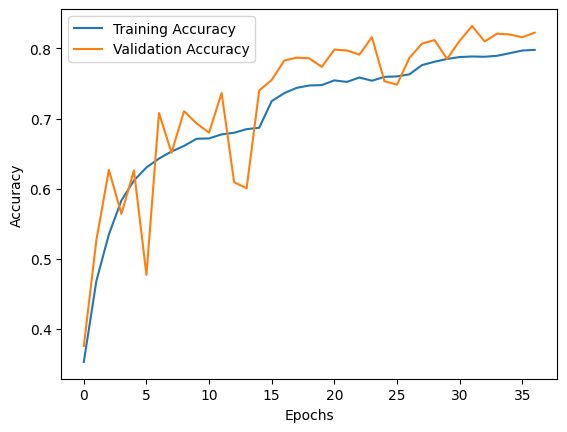

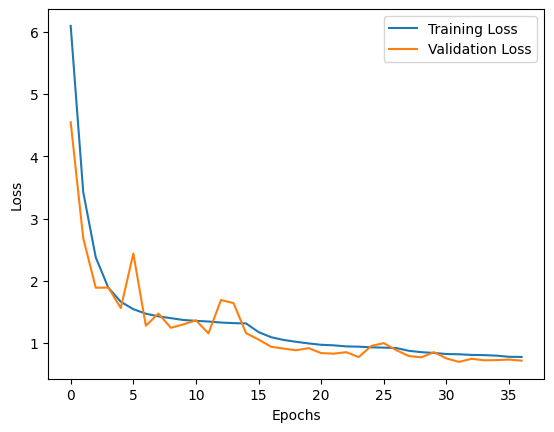

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8281 - loss: 0.7100
Test Loss: 0.6924
Test Accuracy: 0.8334


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


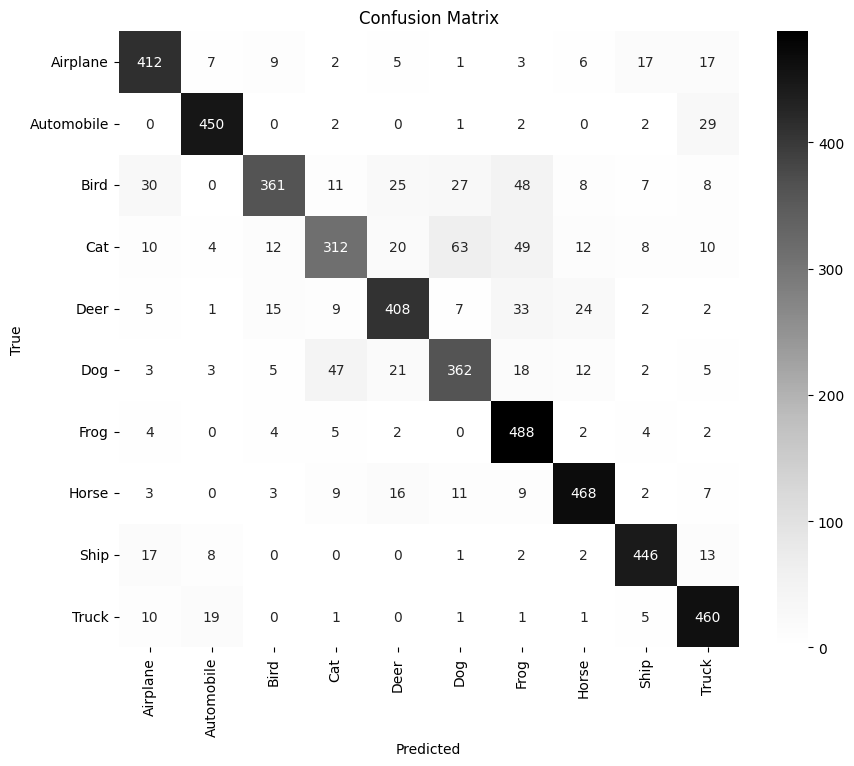

In [ ]:
# Generate predictions on the test set
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# CIFAR-10 class names
cifar10_classes = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Grays', xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Define the CNN Model with 3x3 size

In [ ]:
# Define the CNN model architecture with 10 Conv2D layers
model = Sequential([
    Input(shape=(32, 32, 3)),                      # Explicitly define the input shape

    # Block 1: 2 Conv2D layers + BatchNormalization + MaxPooling + Dropout
    Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 2: 2 Conv2D layers + BatchNormalization + MaxPooling + Dropout
    Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 3: 2 Conv2D layers + BatchNormalization + MaxPooling + Dropout
    Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 4: 2 Conv2D layers + BatchNormalization + MaxPooling + Dropout
    Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 5: 2 Conv2D layers (10th Conv2D added here) + BatchNormalization + MaxPooling + Dropout
    Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fully connected layers
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])

# Compiling the Model

In [ ]:
# Compile model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Model

In [ ]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),              # Stop if no improvement
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, verbose=1, min_lr=1e-7)                          # Reduce learning rate
]

# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),  # Training data with augmentation
    epochs=50,
    validation_data=(x_test, y_test),              # Validation data
    callbacks=callbacks                            # Add callbacks
)

model.save('/content/drive/MyDrive/CNN_with_more_Layers_model.h5')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 79s 75ms/step - accuracy: 0.2137 - loss: 29.0030 - val_accuracy: 0.3800 - val_loss: 14.6267 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - accuracy: 0.4021 - loss: 11.8374 - val_accuracy: 0.3842 - val_loss: 6.0807 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 86s 58ms/step - accuracy: 0.4840 - loss: 4.8288 - val_accuracy: 0.5072 - val_loss: 2.9759 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - accuracy: 0.5297 - loss: 2.6888 - val_accuracy: 0.5994 - val_loss: 2.0417 - learning_rate: 0.0010
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 64ms/step - accuracy: 0.5693 - loss: 2.0979 - val_accuracy: 0.5798 - val_loss: 1.9807 - learning_rate: 0.0010
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 79s 60ms/step - accuracy: 0.5979 - loss: 1.8849 - val_accuracy: 0.5630 - val_loss: 1.9302 - learning_rate: 0.0010
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 84s 62ms/step - accuracy: 0.6341 - loss: 1.7

# Visualize Training History

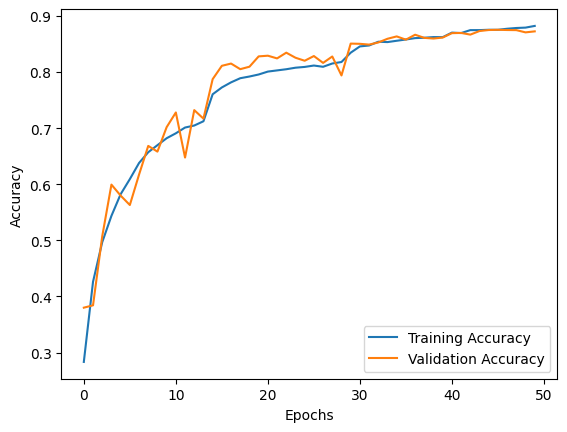

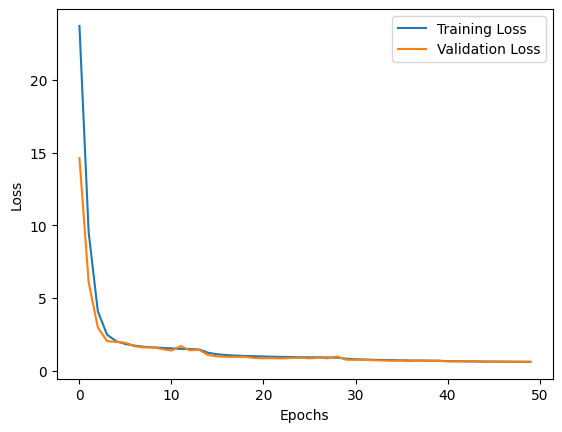

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Model Evaluation

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8669 - loss: 0.6510
Test Loss: 0.6206
Test Accuracy: 0.8754


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


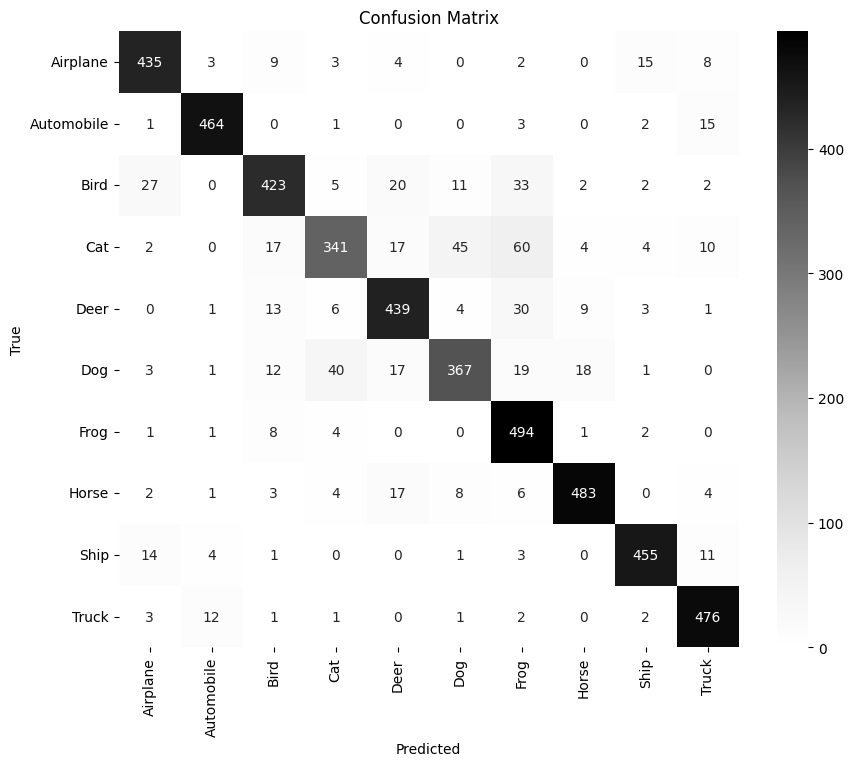

In [ ]:
# Generate predictions on the test set
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# CIFAR-10 class names
cifar10_classes = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Grays', xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Importing Pretrained VGG 16 Model

In [ ]:
def build_vgg16_model():
    """
    Build a VGG16-based model for CIFAR-10 dataset.

    Returns:
        model: A compiled Keras model.
    """
    # Load the VGG16 model without the top layer
    base_model = VGG16(include_top=False, input_shape=(32, 32, 3), weights='imagenet')

    # Unfreeze the last two layers of the base model
    for layer in base_model.layers[:-2]:
        layer.trainable = False

    # Create the model
    model = Sequential([
        base_model,  # Pre-trained VGG16 base
        Flatten(),  # Flatten the output of the VGG16 base
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(10, activation='softmax')  # Output layer for 10 classes
    ])

    # Compile the model
    model.compile(
        optimizer= Adamax(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# Training the VGG16 Model

In [ ]:
# Build the model
model = build_vgg16_model()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
     ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, verbose=1, min_lr=1e-7)
]

# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    validation_data=datagen.flow(x_val, y_val, batch_size=64),
    epochs=50,
    batch_size=64,
    callbacks=callbacks
)
model.save('/content/drive/MyDrive/VGG16_model.h5')

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 62ms/step - accuracy: 0.3746 - loss: 4.0357 - val_accuracy: 0.5598 - val_loss: 1.9650 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 75s 57ms/step - accuracy: 0.5456 - loss: 1.8843 - val_accuracy: 0.5858 - val_loss: 1.4663 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - accuracy: 0.5754 - loss: 1.4653 - val_accuracy: 0.6026 - val_loss: 1.3052 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - accuracy: 0.5980 - loss: 1.3054 - val_accuracy: 0.6220 - val_loss: 1.2004 - learning_rate: 0.0010
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step - accuracy: 0.6045 - loss: 1.2426 - val_accuracy: 0.6118 - val_loss: 1.1967 - learning_rate: 0.0010
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 57ms/step - accuracy: 0.6157 - loss: 1.2057 - val_accuracy: 0.6278 - val_loss: 1.1668 - learning_rate: 0.0010
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 58ms/step - accuracy: 0.6227 - l

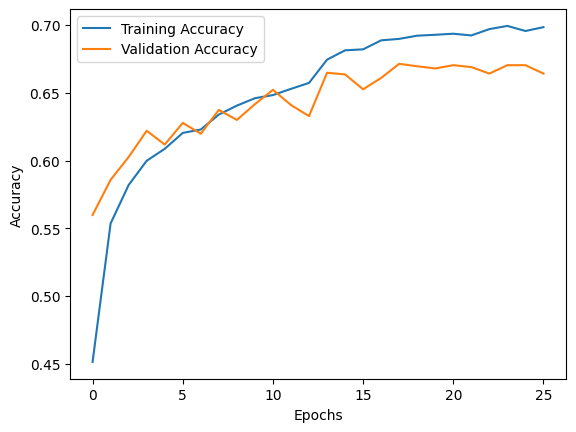

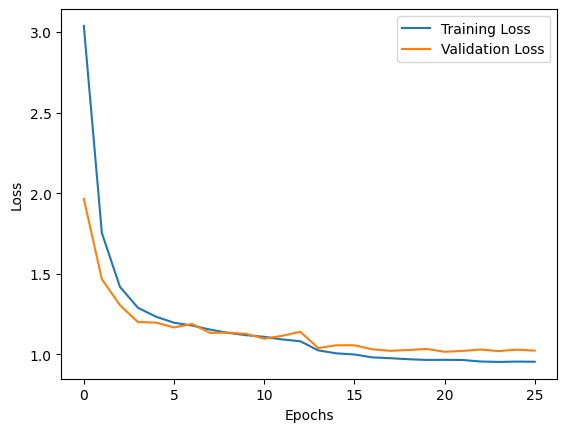

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Evaluating the VGG16 Model

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss for VGG16: {test_loss}, Test Accuracy of VGG16: {test_accuracy}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7092 - loss: 0.9177
Test Loss for VGG16: 0.9220261573791504, Test Accuracy of VGG16: 0.703000009059906


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


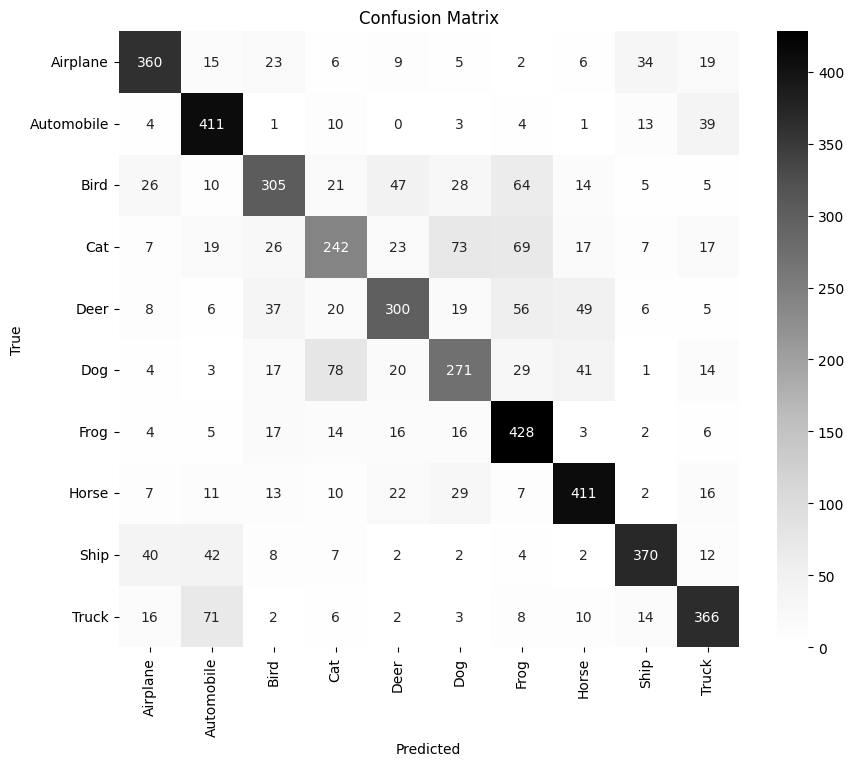

In [ ]:
# Generate predictions on the test set
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# CIFAR-10 class names
cifar10_classes = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Grays', xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Importing Resnet50 Model

In [ ]:
def build_resnet50_model():
    """
    Build a ResNet50-based model for CIFAR-10 dataset.

    Returns:
        model: A compiled Keras model.
    """
    # Load the ResNet50 model without the top layer
    base_model = ResNet50(include_top=False, input_shape=(32, 32, 3), weights='imagenet')

    # Unfreeze the last three layers of the base model
    for layer in base_model.layers[:-5]:
        layer.trainable = False

    # Create the model
    model = Sequential([
        base_model,  # Pre-trained ResNet50 base
        Flatten(),  # Flatten the output of the ResNet50 base
        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(10, activation='softmax')  # Output layer for 10 classes
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# Training the Resnet50 Model

In [ ]:
model = build_resnet50_model()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
     ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, verbose=1, min_lr=1e-7)
]

# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    validation_data=datagen.flow(x_val, y_val, batch_size=64),
    epochs=50,
    batch_size=64,
    callbacks=callbacks
)

model.save('/content/drive/MyDrive/Resnet50_model.h5')

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 77s 69ms/step - accuracy: 0.1859 - loss: 4.5395 - val_accuracy: 0.2244 - val_loss: 2.2461 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 65s 59ms/step - accuracy: 0.2812 - loss: 2.0677 - val_accuracy: 0.1368 - val_loss: 4.8728 - learning_rate: 0.0010
Epoch 3/50
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3116 - loss: 1.9769
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 59ms/step - accuracy: 0.3116 - loss: 1.9769 - val_accuracy: 0.1640 - val_loss: 2.6491 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 58ms/step - accuracy: 0.3384 - loss: 1.8941 - val_accuracy: 0.3514 - val_loss: 1.8209 - learning_rate: 3.0000e-04
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 58ms/step - accuracy: 0.3561 - loss: 1.8618 - val_accuracy: 0.2830 - val_loss: 1.9988 - learning_rate: 3.0000e-04
Epoch 6/50
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.360

# Evaluating the Model

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss For Resnet50: {test_loss}, Test Accuracy For Resnet50: {test_accuracy}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.4460 - loss: 1.5847
Test Loss For Resnet50: 1.5843567848205566, Test Accuracy For Resnet50: 0.44940000772476196


157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step


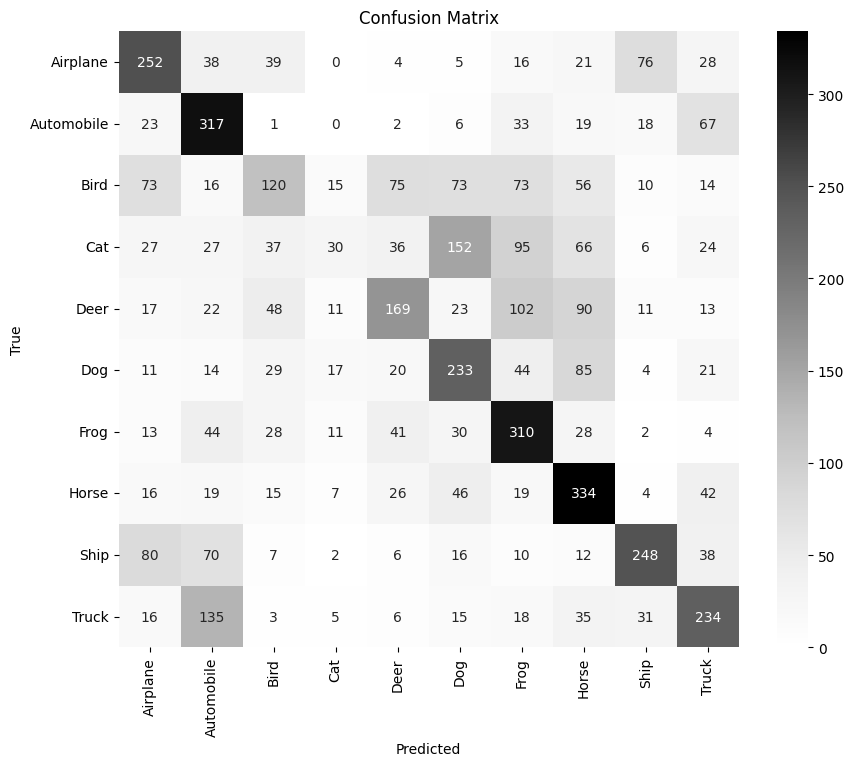

In [ ]:
# Generate predictions on the test set
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# CIFAR-10 class names
cifar10_classes = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Grays', xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()